# Standford 224d Assigment3: Full class sentiment

This excercise look at Stanford NLP Socher's 224d class assigment (Assigment3). But instead using simplify standford sentiment treebank data as the assigment require this excercise look at full classification (positive+, positive, neutral, negative, negative-) of the same data. The reason the scope of the assigment is reduced to simplify classification is to reduce training time as to fit class timeline.  The purpose of this exercise howerer to analyze full classifications of the same problem so one can gain insight to RNN and sentiment classification problem itself.

First of all lets talk about the algorithm. The assignment call for RNN in Tensorflow to score sentence sentiment. The data given as sentence represented as tree. The tree contains words, nodes and labels. Each word (leaf) has a label and each node (which is combination of word-word, word-node, node-node) has a label. The label of root is the sentence sentiment label. Student to train with these trees and predict the root label of test data. 

To train (and also to predict), we rollout each senctence into its own tree structure which essentially create its own RNN stucture/model. The words are represented as word embbeding (co-occurance weight think of word2vec) with size of vocab_size * embedding_size. The words shareed neural weight (onward called U) size of embedded_size * labels_size(clasifications) and bias (onward called bs) size of labels(classification). Softmax of U and bs predict word label. 

In this case labels_sizes is 5 (0 to 4) and embedded_size is hyperparameter which student can adjust to optimal score.

All train, dev and test are given as tree. Thus in the real live application would include parser which is not scope of this assigment 

### import object and sets hyperparameter

In [1]:
%cd "C:\Users\h_agu\Desktop\machine_learning\cs224d\assignment3\codebase_release"
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import itertools
import shutil
import tensorflow as tf
import tree as tr
from utils import Vocab
import pickle

#from memory_profiler import profile

printable = set({
 '0','1','2','3','4','5','6','7',
 '8','9','A','B','C','D','E','F',
 'G','H','I','J','K','L','M','N',
 'O','P','Q','R','S','T','U','V',
 'W','X','Y','Z','a','b','c','d',
 'e','f','g','h','i','j','k','l',
 'm','n','o','p','q','r','s','t',
 'u','v','w','x','y','z','.'})

C:\Users\h_agu\Desktop\machine_learning\cs224d\assignment3\codebase_release


In [2]:
RESET_AFTER = 50
class Config(object):
    """Holds model hyperparams and data information.
       Model objects are passed a Config() object at instantiation.
    """
    embed_size = 35
    #embed_size = 70
    label_size = 5
    early_stopping = 2
    anneal_threshold = 0.99
    anneal_by = 1.5
    #max_epochs = 35
    max_epochs = 1
    lr = 0.05
    l2 = 0.04
    zr = 1e-9
    model_name = 'rnn_embed=%d_l2=%f_lr=%f.weights'%(embed_size, l2, lr)

### Load data and add words to vocabulary. 

data note:
each data represent a sentence and more. The data contains :
1. sentence sentiment score or root score (0/-- to 4/++).  
2. each word (a leaf) score 
3. node score which can be combinded score two words, or a word and a node, or node with other node.

for example:

    (3 (3 Deliciously) (1 (1 slow) (2 .)))
     |                  ^  ^   ^    ^  ^
     |                  |  |   |    |  a leaf/word '.' count as word
     |                  |  |   |    score for '.' (2) which is nuetral
     |                  |  |   leaf/word 'slow' 
     |                  |  score for 'slow' (1) which is -    
     |                  a node and score for word 'slow' and '.'
     a root score (3) which is +
 
 another view:
 
            root(3)
         _____|______
        |            | 
        |           node(1)
        |              ___|__
        |             |      |
    Deliciously(3) slow(1) .(2)
  
tree.num_words() is giving wrong word count as it count all labels the sentance which also include node's label. it return 5 for example above

In [3]:
#vocab=Vocab()
cfg = Config()

In [4]:
def load_data():
    import tree as tr
    train_data, val_data, test_data = tr.data(700, 100, 200)
    train_sentences=[t.get_words() for t in train_data]
    vocab.construct(list(itertools.chain.from_iterable(train_sentences)))
    return train_data, val_data, test_data

#train_data, val_data, test_data = load_data()

In [5]:
def load_saved(fname):
    
    with open(fname +'weigths.train.pickle','rb') as f:
        train_data=pickle.load(f)

    with open(fname+'weigths.val.pickle','rb') as f:
        val_data=pickle.load(f)
        
    with open(fname+'weigths.test.pickle','rb') as f:
        test_data=pickle.load(f)
        
    with open(fname+'weigths.vocab.pickle','rb') as f:
        vocab=pickle.load(f)

    with open(fname+'weigths.config.pickle','rb') as f:
        config=pickle.load(f)
        
    return train_data,val_data,test_data,vocab,config

### Tensorflow graph 

In [5]:
def add_model_vars1():
    with tf.variable_scope("projection"):
        U=tf.get_variable("U",[cfg.label_size , cfg.embed_size],initializer=tf.random_uniform_initializer(-0.01,0.01))
        bs=tf.get_variable("bs",[1,cfg.label_size],initializer=tf.random_uniform_initializer(-0.01,0.01))
    
    with tf.variable_scope("hidden"):
        W=tf.get_variable("W",[2*cfg.embed_size, cfg.embed_size],initializer=tf.random_uniform_initializer(-0.01,0.01))
        b=tf.get_variable("b",[1,cfg.embed_size],initializer=tf.random_uniform_initializer(-0.01,0.01))
        
    with tf.variable_scope("embedding"):
        embedding = tf.get_variable("embedding",[len(vocab.word_freq),cfg.embed_size]
                                    ,initializer=tf.random_uniform_initializer(-0.01,0.01))

In [6]:
def add_model_vars2():
    with tf.variable_scope("projection"):
        U=tf.get_variable("U",[cfg.label_size , cfg.embed_size],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.01))
        bs=tf.get_variable("bs",[1,cfg.label_size],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.01))
    
    with tf.variable_scope("hidden"):
        W=tf.get_variable("W",[2*cfg.embed_size, cfg.embed_size],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.01))
        b=tf.get_variable("b",[1,cfg.embed_size],initializer=tf.random_normal_initializer(mean=0.0,stddev=0.01))
        
    with tf.variable_scope("embedding"):
        embedding = tf.get_variable("embedding",[len(vocab.word_freq),cfg.embed_size])

In [6]:
def add_model_vars():
    with tf.variable_scope("projection"):
        U=tf.get_variable("U",[cfg.label_size , cfg.embed_size])
        bs=tf.get_variable("bs",initializer=tf.zeros_initializer(shape=[1,cfg.label_size]))
    
    with tf.variable_scope("hidden"):
        W=tf.get_variable("W",[2*cfg.embed_size, cfg.embed_size])
        b=tf.get_variable("b", initializer=tf.zeros_initializer(shape=[1,cfg.embed_size]))
        
    with tf.variable_scope("embedding"):
        embedding = tf.get_variable("embedding",[len(vocab.word_freq),cfg.embed_size])

In [7]:
def model(node):
    #wordRef=dict()
    currentTensor=None
    tensor_nodes=dict()
    with tf.variable_scope("embedding",reuse=True):
        embedding = tf.get_variable("embedding")
        
    with tf.variable_scope("hidden",reuse=True):
        W=tf.get_variable("W")
        b=tf.get_variable("b")    

    if node.isLeaf:
        #wordRef[node]=node.word
        #wd=''
        #wd=wd.join(filter(lambda x: x in printable,node.word))
        #if len(wd) == 0:
        #    wd="input"
        #print(node.word)
        
        
        #with tf.name_scope(wd):
        with tf.name_scope("input"):
            currentTensor=embedding[vocab.encode(node.word)]

    else:
        tensor_nodes.update(model(node.left))
        tensor_nodes.update(model(node.right))
        l=[tensor_nodes[node.left]]
        r=[tensor_nodes[node.right]]
        
        with tf.name_scope("node"):
            a=tf.concat(1,[l,r])
            h=tf.reshape(tf.matmul(a,W)+b,[cfg.embed_size])
            currentTensor=tf.nn.relu(h)
            
    tensor_nodes[node]=currentTensor
    return tensor_nodes

In [8]:
def projection(h):
    
    #global U,bs
    with tf.variable_scope("projection",reuse=True):
        U=tf.get_variable("U")
        bs=tf.get_variable("bs")
    with tf.name_scope("node_score"):
        #h=tf.reshape(h,[1,cfg.embed_size])
        logits=tf.matmul(h,U,transpose_b=True)
        logits=logits + bs
        #yhat=tf.nn.softmax(yhat+bs)
    #yhat=np.dot(U,h)+bs
    #yhat=softmax(yhat)
    return logits

In [9]:
def cost(logits, labels):
    with tf.variable_scope("hidden",reuse=True):
        W=tf.get_variable("W")
        b=tf.get_variable("b")

    with tf.variable_scope("projection",reuse=True):
        U=tf.get_variable("U")
        bs=tf.get_variable("bs")
    
    #print(labels)
    
    loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,tf.constant(labels), name="cross_entropy_loss")) 
    loss = loss + cfg.l2 * (tf.nn.l2_loss(W) + tf.nn.l2_loss(b) + tf.nn.l2_loss(U) + tf.nn.l2_loss(bs) )
    return loss

In [10]:
def predict(logits):
    return tf.argmax(logits,1)

In [11]:
def predictions(data, wloss=True, root=True, save_dir=None, verbose=True):
    global tensor_nodes,labels
    
    if save_dir is None :
        print("no saved file")
        return None
    
    tf.reset_default_graph()
    add_model_vars()
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess,save_dir)  
    
    root=False
    #accu=[]
    loss=[]
    tensors=[]
    lbl=[]
    
    for t in data:
        tensor_nodes=dict()
        labels=[]
        tensor_nodes=model(t.root)
        
        
        #tensors+=[t for node ,t in tensor_nodes.items() if node.label!=2]
        #_=[lbl.append(l) node ,t in tensor_nodes.items() if node.label!=2]
        
        tensors+=[t for node ,t in tensor_nodes.items()]
        _=[lbl.append(node.label) for node ,t in tensor_nodes.items()]
        
    #print(lbl)
    #print(tensors)
    logits=projection(tensors)
    score=predict(logits) 
    yhat=sess.run([score])
    yhat=np.array(yhat[0],dtype="int64")
    lbl=np.array(lbl,dtype="int64")
    
    #print(yhat.shape)
    #print(lbl.shape)
    
    if verbose:
        print("\t\t\t\t\tactual label")
        print("\tpred","\tpos","\tneg","\t0","\t1", "\t2", "\t3", "\t4")
        for l in range(5):
            row=[]
            idx=yhat[:]==l
            tru=idx.sum()
            sets=lbl[idx]
            pos=(sets==l).sum()
            neg=sets!=l
            #actual=[]
            #print(len(sets))
            row.append(l)
            row.append(tru)
            row.append(pos)
            row.append(neg.sum())
            for a in range(5):
                cnt=(sets[neg]==a).sum()
                row.append(cnt)
                #actual.append()
            #print(actual)
        
            print(row[0],"\t",row[1],"\t",row[2],"\t",row[3],"\t",row[4],"\t",row[5],"\t",row[6],"\t",row[7],"\t",row[8])
        
    acc=np.equal(yhat,lbl).mean
    
    if wloss:
        ce=cost(logits,lbl)
        loss.append(sess.run([ce]))
            #print(len(labels))
            #loss=loss[0]/len(data)
    else:
        loss=0
    

    return acc,loss

In [12]:
def debugTensorboard():
    
    with tf.variable_scope("hidden",reuse=True):
        W=tf.get_variable("W")
        b=tf.get_variable("b")
    
    with tf.variable_scope("embedding",reuse=True):
        embedding = tf.get_variable("embedding")
    
    tf.summary.histogram('W',W)
    tf.summary.histogram('b',b)
    tf.summary.histogram('embedding',embedding)
    
    with tf.variable_scope("projection",reuse=True):
        U=tf.get_variable("U")
        bs=tf.get_variable("bs")

    tf.summary.histogram('U',U)
    tf.summary.histogram('bs',bs)
    
    merge = tf.summary.merge_all()
    return merge

In [13]:
def savedTensors(sess,saver):
    global save_dir, log_dir
    time_stamp=str(time.time())
    
    with tf.variable_scope("hidden",reuse=True):
        W=tf.get_variable("W")
        b=tf.get_variable("b")
    
    with tf.variable_scope("embedding",reuse=True):
        embedding = tf.get_variable("embedding")
    
    with tf.variable_scope("projection",reuse=True):
        U=tf.get_variable("U")
        bs=tf.get_variable("bs")
        
    save_path = saver.save(sess, save_dir)
        
    U,bs,b,W,embedding = sess.run([U,bs,b,W,embedding])
    
    #u=[]
    #w=[]
    #e=[]
    
    #print("file: ", save_dir + '.W.txt')
    #print("isfile: ", os.path.isfile(save_dir + '.W.txt'))
    
   #if os.path.isfile(save_dir + '.U.txt'):
   #     u=np.loadtxt(save_dir + '.U.txt')
   #     u=u.tolist()
    
    #if os.path.isfile(save_dir + '.W.txt'):
    #    w=np.loadtxt(save_dir + '.W.txt')
    #    print("w",w.shape)
    #    w=w.tolist()
    
    #if os.path.isfile(save_dir + '.embedding.txt'):
    #    e=np.loadtxt(save_dir + '.embedding.txt')
    #    e=e.tolist()
        
    #u.append([np.ravel(np.array(U)).T.tolist()])
    #w.append([np.ravel(np.array(W)).T.tolist()])
    #e.append([np.ravel(np.array(embedding)).T.tolist()])
    
    #print("\n",len(w))
    u=[np.ravel(np.array(U)).T.tolist()]
    _bs=[np.ravel(np.array(bs)).T.tolist()]
    #print(_bs())
    w=[np.ravel(np.array(W)).T.tolist()]
    _b=[np.ravel(np.array(b)).T.tolist()]
    e=[np.ravel(np.array(embedding)).T.tolist()]
        
    np.savetxt(save_dir + '.U.' + time_stamp + '.txt', u)
    np.savetxt(save_dir + '.bs.' + time_stamp + '.txt', _bs)
    np.savetxt(save_dir + '.W.' + time_stamp + '.txt', w)
    np.savetxt(save_dir + '.b.' + time_stamp + '.txt', _b)
    np.savetxt(save_dir + '.embedding.' + time_stamp + '.txt', e)
    

In [14]:
def run_epoch(train_data, nsave=2, verbose=True, debug=True, fname=None, isNew=False):
    global save_dir,log_dir,labels, tensor_nodes,cfg
    itrain=1
    loss_history=[]
    step=0
    nsave=RESET_AFTER
    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    #isNew=False
    print("cfg.lr: ",cfg.lr)
    
    while step < len(train_data):
        #print(step)
        with tf.Graph().as_default(), tf.Session(config=config) as sess:
            add_model_vars()
            saver = tf.train.Saver()
            if isNew:
                init=tf.global_variables_initializer()
                sess.run(init)
                isNew=False
                print("\ninit global\n")
            else:
                if fname is not None:
                    #print("\nrestore fname\n")
                    fname=fname + "weigths"
                    saver.restore(sess,fname)
                    
                    fname=None
                    with tf.variable_scope("hidden",reuse=True):
                        W=tf.get_variable("W")
    
                    with tf.variable_scope("embedding",reuse=True):
                        embedding = tf.get_variable("embedding")
    
                    with tf.variable_scope("projection",reuse=True):
                        U=tf.get_variable("U")
                    
                    W=tf.nn.dropout(W,0.5)
                    embedding=tf.nn.dropout(embedding,0.5)
                    U=tf.nn.dropout(U,0.5)
                        
                else:
                    #print("\nrestore save_dir\n")
                    saver.restore(sess,save_dir)    
                    
            for _ in range(RESET_AFTER):
                if step == len(train_data):
                    break
                t=train_data[step]
                #with tf.name_scope("model"):
                tensor_nodes=dict()
                labels=[]
                tensor_nodes=model(t.root)
                
                #if step/2==0:
                tensors=[[t] for node,t in tensor_nodes.items()]
                _=[labels.append(node.label) for node,t in tensor_nodes.items()]
                #else:
                #    tensors=[[t] for node,t in tensor_nodes.items() if node.label!=2]
                #    _=[labels.append(node.label) for node,t in tensor_nodes.items() if node.label!=2]               

                if len(tensors) > 0:
                    tensors=tf.concat(0,tensors)
                    with tf.name_scope("cross_entropy"):
                    
                    #print(tensor_nodes)
                        logits=projection(tensors)
                        pred=predict(logits)
                        loss=cost(logits,labels)
                    #tf.summary.scalar('cross-entrophy',ce)
                    op=tf.train.GradientDescentOptimizer(cfg.lr).minimize(loss)
                    

                    cx,o = sess.run([loss,op])
                    loss_history.append(cx)
                    if verbose:
                        sys.stdout.write('\r{} / {} :    loss = {}'.format(
                        step + 1, len(train_data), np.mean(loss_history)))
                        sys.stdout.flush()
                
                if step == 0 and isNew:
                    savedTensors(sess,saver)
                step=step+1
                
            if debug:
                merge=debugTensorboard()
                writer = tf.summary.FileWriter(log_dir, sess.graph) 
                cx,o,summ = sess.run([ce,op,merge])
                writer.add_summary(summ)
                step=step+1
                
            savedTensors(sess,saver)
    
    return loss_history

In [15]:
#@profile
def train(fname=None):
    global save_dir, log_dir, train_data, val_data, test_data, vocab, cfg

    cfg=Config()
    cfg.max_epochs=10
    prev_loss=0
    loss=0
    all_train_loss=[]
    val_acc=[]
    train_acc=[]
    
    print(cfg.model_name)
    
    if True:
        start_time=str(time.time())
        log_dir=''
        log_dir="tensorboard\log\\" + start_time + "\\"
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        save_dir=''
        save_dir="weights\\" + start_time + "\\"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_dir=save_dir + "weigths"
    
    print(save_dir)
    
    for epoch in range(cfg.max_epochs):
        prev_loss=loss
        print ("\nepoch: ",epoch)
        start=time.time()
        
        if epoch == 0:
            if fname is None:
                vocab=Vocab()
                train_data, val_data, test_data = load_data()
                data = train_data
                #cfg=Config()
                loss=run_epoch(data,debug=False,isNew=True)
            else:
                train_data,val_data,test_data,vocab,cfg =load_saved(fname)
                #cfg.lr=0.022222222222222223
                data = train_data
                loss=run_epoch(data,debug=False,fname=fname)
        else:
            #cfg=Config()
            loss=run_epoch(data,debug=False)
        #all_train_loss.append(loss)
        all_train_loss+=[l for l in loss]
        loss=np.mean(loss)
        end=time.time()
        runtime=end-start
        print ("\nepoch ",epoch," end in ",runtime," seconds, loss: ",loss)
        if epoch !=0 and prev_loss * cfg.anneal_threshold < loss:
            cfg.lr/=cfg.anneal_by
            print('annealed lr to %f'%cfg.lr)
        
        shutil.copyfile(save_dir + ".data-00000-of-00001", save_dir + ".data." + str(epoch))
        shutil.copyfile(save_dir + ".index", save_dir + ".index." + str(epoch))
        shutil.copyfile(save_dir + ".meta", save_dir + ".meta." + str(epoch))
        
        # calc validation acc
        print("\nvalidation:")
        val_acc,val_loss=predictions(val_data, wloss=True, root=True, save_dir=save_dir, verbose=False)
        print("val_acc:", val_acc(), " val_loss:",np.mean(val_loss)/len(val_data))
        # calc train acc
        print("test:")
        test_acc, test_loss=predictions(test_data, wloss=False, root=False, save_dir=save_dir, verbose=False)
        print("test_acc:", test_acc(), " val_loss:") #,np.mean(test_loss)/len(test_data))
        print("train:")
        train_acc,train_loss=predictions(train_data, wloss=True, root=True, save_dir=save_dir, verbose=True)
        print("train_acc:", train_acc(), " val_loss:",np.mean(train_loss)/len(train_data))
        
        if epoch == 0:
            with open(save_dir+'.train.pickle','wb') as f:
                pickle.dump(train_data,f,0)

            with open(save_dir+'.val.pickle','wb') as f:
                pickle.dump(val_data,f,0)
    
            with open(save_dir+'.test.pickle','wb') as f:
                pickle.dump(test_data,f,0)
    
            with open(save_dir+'.vocab.pickle','wb') as f:
                pickle.dump(vocab,f,0)
    
        with open(save_dir+'.config.pickle','wb') as f:
            pickle.dump(cfg,f,0)           
        
        end=time.time()
        
        runtime=end-start
        
        print("total time:",runtime)
        
    # save loss
    np.savetxt(save_dir+'.' + cfg.model_name + '.loss.txt',np.array(all_train_loss))
    

    # save accuracies

In [15]:
train()

rnn_embed=35_l2=0.040000_lr=0.050000.weights
weights\1503589480.2512481\weigths

epoch:  0
Loading train trees..
Loading dev trees..
Loading test trees..
pos+:  1852  pos:  3111  neut:  2242  neg:  3140  neg+:  1510
3121.0 total words with 1162 uniques
cfg.lr:  0.05

init global

700 / 700 :    loss = 9.0970954895019536
epoch  0  end in  575.7278201580048  seconds, loss:  9.0971

validation:
val_acc: 0.587883959044  val_loss: 12.5877319336
test:
test_acc: 0.596385542169  val_loss:
train:
					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4
0 	 513 	 116 	 397 	 0 	 87 	 45 	 124 	 141
1 	 1126 	 282 	 844 	 174 	 0 	 253 	 254 	 163
2 	 3811 	 2878 	 933 	 98 	 344 	 0 	 374 	 117
3 	 92 	 82 	 10 	 0 	 0 	 0 	 0 	 10
4 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0
train_acc: 0.605918440996  val_loss: 7.58856933594
total time: 662.9092392921448

epoch:  1
cfg.lr:  0.05
700 / 700 :    loss = 7.7873129844665535
epoch  1  end in  547.628219127655  seconds, loss:  7.78731

validation:
val_acc: 0.62457337884

In [17]:
train()

rnn_embed=35_l2=0.030000_lr=0.050000.weights
weights\1503422080.64624\weigths

epoch:  0
Loading train trees..
Loading dev trees..
Loading test trees..
pos+:  1852  pos:  3111  neut:  2242  neg:  3140  neg+:  1510
3121.0 total words with 1162 uniques
cfg.lr:  0.05

init global

700 / 700 :    loss = 9.0531711578369141
epoch  0  end in  622.5025289058685  seconds, loss:  9.05317

validation:
val_acc: 0.613481228669  val_loss: 11.6758776855
test:
test_acc: 0.602409638554  val_loss:
train:
					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4
0 	 13 	 13 	 0 	 0 	 0 	 0 	 0 	 0
1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0
2 	 4061 	 2971 	 1090 	 123 	 414 	 0 	 407 	 146
3 	 1077 	 344 	 733 	 145 	 252 	 183 	 0 	 153
4 	 391 	 132 	 259 	 107 	 47 	 22 	 83 	 0
train_acc: 0.624323348971  val_loss: 7.20160435268
total time: 720.8153991699219

epoch:  1
cfg.lr:  0.05
700 / 700 :    loss = 7.6744084358215335
epoch  1  end in  615.0517201423645  seconds, loss:  7.67441

validation:
val_acc: 0.618600682594

In [20]:
train()

rnn_embed=35_l2=0.040000_lr=0.050000.weights
weights\1503441661.1814692\weigths

epoch:  0
Loading train trees..
Loading dev trees..
Loading test trees..
pos+:  1852  pos:  3111  neut:  2242  neg:  3140  neg+:  1510
3121.0 total words with 1162 uniques
cfg.lr:  0.05

init global

700 / 700 :    loss = 9.1815519332885744
epoch  0  end in  649.348212480545  seconds, loss:  9.18155

validation:
val_acc: 0.619453924915  val_loss: 11.4764953613
test:
test_acc: 0.610441767068  val_loss:
train:
					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4
0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0
1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0
2 	 4295 	 3032 	 1263 	 156 	 471 	 0 	 475 	 161
3 	 1035 	 311 	 724 	 169 	 225 	 139 	 0 	 191
4 	 212 	 79 	 133 	 63 	 17 	 5 	 48 	 0
train_acc: 0.617466618549  val_loss: 7.38057826451
total time: 746.6796576976776

epoch:  1
cfg.lr:  0.05
700 / 700 :    loss = 7.8691568374633795
epoch  1  end in  603.8729434013367  seconds, loss:  7.86916

validation:
val_acc: 0.644197952218  va

In [15]:
train()

rnn_embed=35_l2=0.040000_lr=0.050000.weights
weights\1502899761.548873\weigths

epoch:  0
Loading train trees..
Loading dev trees..
Loading test trees..
pos+:  1852  pos:  3111  neut:  2242  neg:  3140  neg+:  1510
3121.0 total words with 1162 uniques
cfg.lr:  0.05

init global

700 / 700 :    loss = 9.1547603607177732
epoch  0  end in  618.1739342212677  seconds, loss:  9.15476

validation:
val_acc: 0.62542662116  val_loss: 11.4680651855
test:
test_acc: 0.626907630522  val_loss:
train:
					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4
0 	 6 	 1 	 5 	 0 	 0 	 0 	 0 	 5
1 	 31 	 21 	 10 	 2 	 0 	 0 	 2 	 6
2 	 4372 	 3083 	 1289 	 168 	 500 	 0 	 456 	 165
3 	 1133 	 376 	 757 	 217 	 192 	 93 	 0 	 255
4 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0
train_acc: 0.628112594731  val_loss: 7.24002511161
total time: 712.7560503482819

epoch:  1
cfg.lr:  0.05
700 / 700 :    loss = 7.8414921760559085
epoch  1  end in  591.3074378967285  seconds, loss:  7.84149

validation:
val_acc: 0.652730375427  val_loss:

In [22]:
fname="weights\\1502899761.548873\\weigths"
train_acc,train_loss=predictions(val_data, wloss=True, root=True, save_dir=fname, verbose=True)
print("train_acc:", train_acc(), " val_loss:",np.mean(train_loss)/len(val_data))

					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4
0 	 40 	 27 	 13 	 0 	 6 	 4 	 2 	 1
1 	 123 	 33 	 90 	 13 	 0 	 54 	 15 	 8
2 	 782 	 634 	 148 	 16 	 60 	 0 	 58 	 14
3 	 157 	 69 	 88 	 4 	 19 	 27 	 0 	 38
4 	 70 	 45 	 25 	 1 	 5 	 5 	 14 	 0
train_acc: 0.689419795222  val_loss: 11.0722875977


In [16]:
fname="weights\\1503589480.2512481\\"

In [ ]:
train(fname=fname)

rnn_embed=35_l2=0.040000_lr=0.050000.weights
weights\1503643244.4171886\weigths

epoch:  0
cfg.lr:  0.05
700 / 700 :    loss = 4.6645359992980965
epoch  0  end in  602.413599729538  seconds, loss:  4.66454

validation:
val_acc: 0.637372013652  val_loss: 11.7774975586
test:
test_acc: 0.644176706827  val_loss:
train:
					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4
0 	 626 	 346 	 280 	 0 	 190 	 18 	 36 	 36
1 	 653 	 459 	 194 	 38 	 0 	 81 	 51 	 24
2 	 3267 	 3045 	 222 	 4 	 62 	 0 	 130 	 26
3 	 894 	 612 	 282 	 0 	 2 	 32 	 0 	 248
4 	 102 	 97 	 5 	 0 	 0 	 0 	 5 	 0
train_acc: 0.822627210393  val_loss: 3.827578125
total time: 699.6081681251526

epoch:  1
cfg.lr:  0.05
278 / 700 :    loss = 4.6701579093933105

In [ ]:
train(fname=fname)

rnn_embed=35_l2=0.050000_lr=0.050000.weights
weights\1503398256.2716794\weigths

epoch:  0
cfg.lr:  0.022222222222222223
700 / 700 :    loss = 3.4021170139312744
epoch  0  end in  733.0976247787476  seconds, loss:  3.40212

validation:
val_acc: 0.697098976109  val_loss: 10.0888024902
test:
test_acc: 0.677911646586  val_loss:
train:
					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4
0 	 279 	 255 	 24 	 0 	 21 	 0 	 3 	 0
1 	 859 	 650 	 209 	 132 	 0 	 68 	 8 	 1
2 	 3203 	 3079 	 124 	 1 	 40 	 0 	 78 	 5
3 	 702 	 611 	 91 	 0 	 2 	 27 	 0 	 62
4 	 499 	 363 	 136 	 0 	 0 	 2 	 134 	 0
train_acc: 0.894622879827  val_loss: 2.29525355748
total time: 843.0408868789673

epoch:  1
cfg.lr:  0.022222222222222223
700 / 700 :    loss = 3.3772690296173096
epoch  1  end in  650.6491632461548  seconds, loss:  3.37727
annealed lr to 0.014815

validation:
val_acc: 0.693686006826  val_loss: 9.97728210449
test:
test_acc: 0.686746987952  val_loss:
train:
					actual label
	pred 	pos 	neg 	0 	1 	2 	3 	4

In [3]:
fname='c://Users/h_agu/Desktop/machine_learning/cs224d/assignment3/codebase_release/weights/1502810384.9085138/'

In [5]:
embeddings=np.loadtxt(fname + 'weigths.embedding.txt')
bs=np.loadtxt(fname + 'weigths.bs.txt')
Us=np.loadtxt(fname + 'weigths.U.txt')
b=np.loadtxt(fname + 'weigths.b.txt')
Ws=np.loadtxt(fname + 'weigths.W.txt')

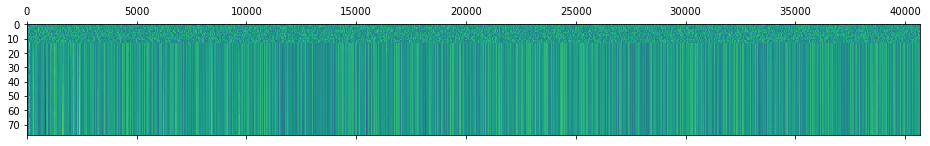

In [20]:
import matplotlib.pyplot as plt
#import numpy as np

plt.matshow(embeddings)
plt.gca().set_aspect('auto')
plt.show()

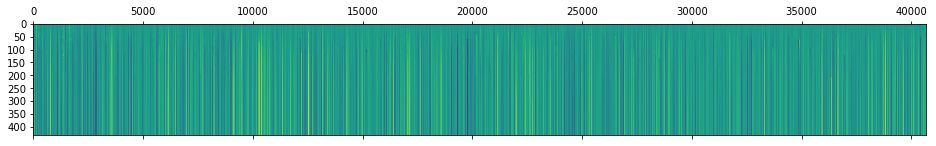

In [6]:
import matplotlib.pyplot as plt
#import numpy as np

plt.matshow(embeddings)
plt.gca().set_aspect('auto')
plt.show()

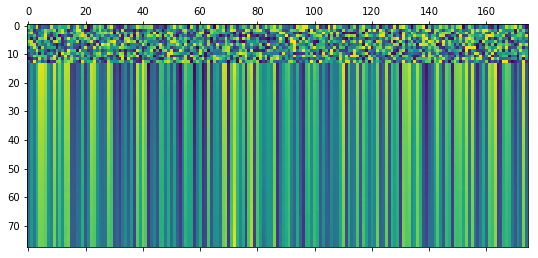

In [21]:
plt.matshow(Us)
plt.gca().set_aspect('auto')
plt.show()

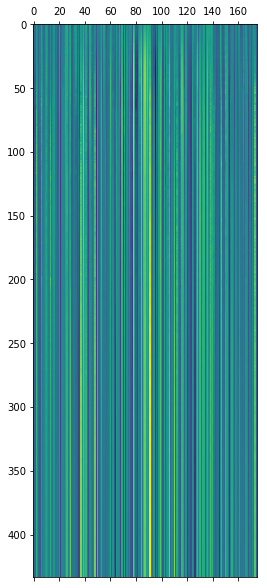

In [7]:
plt.matshow(Us)
plt.gca().set_aspect('auto')
plt.show()

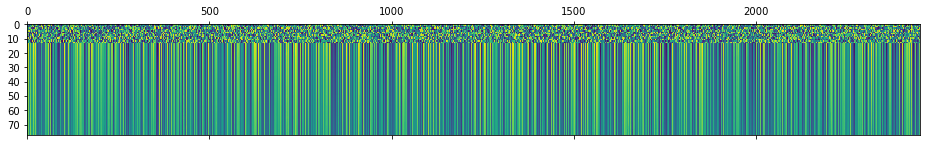

In [22]:
plt.matshow(Ws)
plt.gca().set_aspect('auto')
plt.show()

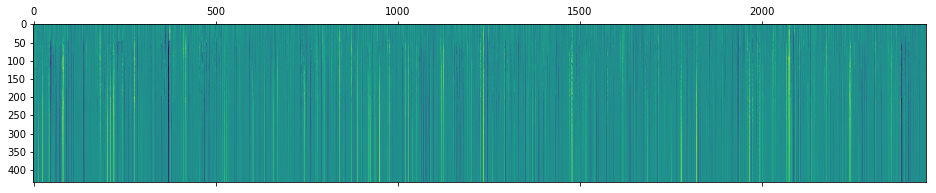

In [8]:
plt.matshow(Ws)
plt.gca().set_aspect('auto')
plt.show()

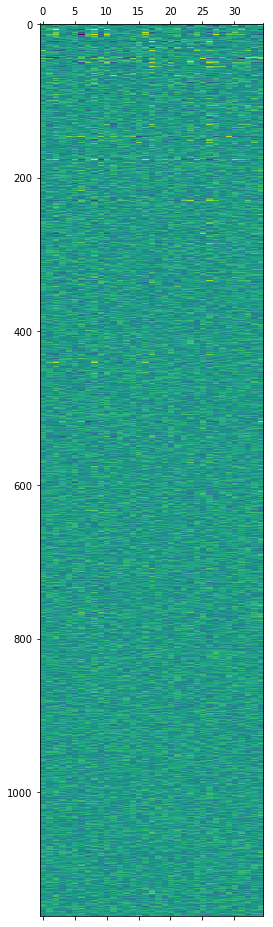

In [26]:
plt.matshow(em)
plt.gca().set_aspect('auto')
plt.show()

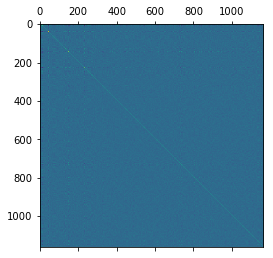

In [35]:
em_x=np.dot(em,em.T)

#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.matshow(em_x)
#plt.gca().set_aspect('auto')
plt.show()
#mt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#plt.show(mt)

In [37]:
U=Us[77].reshape(cfg.label_size , cfg.embed_size)

In [56]:
words_em=[]
words=['good','amazing','sucks','bad']
words_em+=[em[vocab.encode(w)] for w in words]
words_em=np.array(words_em)

In [69]:
res=np.argmax(np.dot(em, U.T),axis=1)

In [92]:
w_idx=np.where(res==0)[0]
for id in w_idx:
    #print(id)
    print(vocab.decode(id))

it
,
adaptation
knees
!
be
piece
character-based
really
horrible
jason
moot
fascinating
pointless
go
melodrama
me
hard-hitting
delicately
exceptional
unwieldy
bond-inspired
morton
nomination
disturbing
take
surface
psychodramatics
compelling
extraordinary
taut
jackson
twirls
lacks
exhilarating
company
heartfelt
zoom
utter
mush
overly
from
fairly
strangers
consider
life-affirming
they
reality-snubbing
remember
gripping
again
acted
puzzling
hilariously
tootsie
failure
writing
farm
chaotic
my
refreshing
ambitious
sign
transgression
woefully
disposible
cusack
amazing
sparse
flawed
once
note
rings
polished
well-structured
job
parody
whatsoever
live-action
staggeringly
nailbiter
phoned-in
cho
gem
laughs
stirring
much
scum
abysmally
bleak
sorely
genuinely
uninteresting
asian
some
make
expectations
unsettling


In [89]:
w_idx[0][0]

20

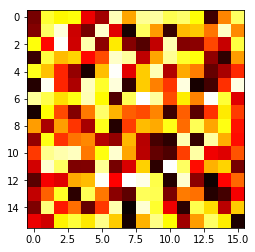

In [53]:
import matplotlib.pyplot as plt
import numpy as np

a = np.random.random((16, 16))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [87]:
def predictions(data, wloss=True, root=True):
    global save_dir,log,labels,acc,tens
    
    if len(save_dir) == 0 :
        print("no saved file")
        return None
    
    tf.reset_default_graph()
    add_model_vars()
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess,save_dir)  
    
    tensors=[]
    labels=[]
    
    for t in data:
        node_tensor=model(t.root)
        
        if root:
            #tensors+=[next(iter(node_tensor.values()))]
            tensors+=[node_tensor[t.root]]
            labels+=[t.root.label]
        else:
            tensors+=[t for idx,t in node_tensor.items()]
            labels+=[l for l in t.labels]
            
    logits=projection(tensors)
    score=predict(logits)
    
    tens,log,acc=sess.run([tensors,logits,score])
    
    accu=np.equal(acc,labels).mean
    
    #print(log)
    #print(labels)
    #print(logits)
    #print(labels)
    
    if wloss:
        ce=cost(logits,labels)
        loss = sess.run([ce])
    else:
        loss=0
    
    return accu,loss

In [70]:
def predictions2(data, wloss=True, root=True):
    global save_dir,log,labels,acc,tens
    
    if len(save_dir) == 0 :
        print("no saved file")
        return None

    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.reset_default_graph()
    hist_loss=[]
    tens=[]
    log=[]
    acc=[]
    labels=[]
    step = 0
    
    while step < len(data):
        with tf.Graph().as_default(), tf.Session(config=config) as sess:
            add_model_vars()
            saver = tf.train.Saver()
            saver.restore(sess,save_dir) 
            for _ in range(RESET_AFTER):
                tensors=[]
                _labels=[]
                t=data[step]
                node_tensor=model(t.root)
                if root:
            #tensors+=[next(iter(node_tensor.values()))]
                    tensors+=[node_tensor[t.root]]
                    labels+=[t.root.label]
                    _labels+=[t.root.label]
                else:
                    tensors+=[t for idx,t in node_tensor.items()]
                    labels+=[l for l in t.labels]
                    _labels+=[l for l in t.labels]
                
                logits=projection(tensors)
                score=predict(logits)
                if wloss:
                    ce=cost(logits,_labels)
                    _tens,_log,_acc,_loss=sess.run([tensors,logits,score,ce])
                    hist_loss.append(_loss)
                    sys.stdout.write('\r{} / {} :    loss = {}'.format(
                    step + 1, len(data), np.mean(hist_loss)))
                    sys.stdout.flush()
                else:
                    _tens,_log,_acc=sess.run([tensors,logits,score])
                step=step+1
                #print(":",len(_tens[0]))
                tens+=[ t.tolist() for t in _tens ]
                #tens+=[t.tolist() for _,t in _tens ]
                #tens.append(_tens)
                log+=[l for l in _log ]
                #log.append(_log)
                acc+=[a for a in _acc ]
                #acc.append(_acc)
                
    loss=np.mean(hist_loss)
    #print(tens)
    accu=np.equal(acc,labels).sum()/len(labels)
    #accu=0
    return accu,loss

In [109]:
save_dir="C:\\Users\\h_agu\\Desktop\\machine_learning\\cs224d\\assignment3\\codebase_release\\weights\\1501602021.1742373\\weigths"

In [108]:
acc

array([2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [107]:
train_data[0].labels

[2, 2, 2, 2, 2, 2, 2, 3, 1]

In [106]:
len(train_data[1].labels)

5

In [71]:
val_acc,val_loss=predictions2(train_data, wloss=True, root=False)

700 / 700 :    loss = 11.191483497619629

In [85]:
val_acc

0.57307831107903284

In [110]:
%%time
val_acc1,val_loss1=predictions(train_data[0:1], wloss=True, root=False)

InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [1,35] rhs shape= [35]
	 [[Node: save/Assign_2 = Assign[T=DT_FLOAT, _class=["loc:@hidden/b"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](hidden/b, save/RestoreV2_2/_3)]]

Caused by op 'save/Assign_2', defined at:
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-110-37dac282f186>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', 'val_acc1,val_loss1=predictions(train_data[0:1], wloss=True, root=False)')
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2115, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-60>", line 2, in time
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\magics\execution.py", line 1180, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "<ipython-input-87-7e2ac4fb4d8e>", line 11, in predictions
    saver = tf.train.Saver()
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 1000, in __init__
    self.build()
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 624, in build
    restore_sequentially, reshape)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 373, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 130, in restore
    self.op.get_shape().is_fully_defined())
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [1,35] rhs shape= [35]
	 [[Node: save/Assign_2 = Assign[T=DT_FLOAT, _class=["loc:@hidden/b"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](hidden/b, save/RestoreV2_2/_3)]]


In [84]:
val_acc1()

0.57307831107903284

In [24]:
_acc,_loss=predictions([train_data[0]], wloss=True, root=False)

Tensor("node_score/add:0", shape=(5, 5), dtype=float32)
[4, 1, 2, 3, 3]


In [26]:
acc

array([2, 2, 2, 2, 2], dtype=int64)

In [27]:
log

array([[-0.60836297, -0.19024912,  1.94025373, -0.36197662, -0.77964377],
       [-0.64183289, -0.02503958,  1.62584841, -0.20586683, -0.75302351],
       [-0.63431513, -0.29243225,  2.0231843 , -0.36385679, -0.73254776],
       [-0.66227418, -0.07807489,  1.59105885, -0.1505824 , -0.7000351 ],
       [-0.63333863, -0.27252918,  2.02847266, -0.35712555, -0.76546383]], dtype=float32)

In [30]:
t=train_data[0]
t.get_words()

['great', 'dragons', '!']

In [31]:
fname='c://Users/h_agu/Desktop/machine_learning/cs224d/assignment3/codebase_release/weights/1501602021.1742373/'
embeddings=np.loadtxt(fname + 'weigths.embedding.tmp.txt')
b_s=np.loadtxt(fname + 'weigths.bs.tmp.txt')
Us=np.loadtxt(fname + 'weigths.U.tmp.txt')
b_=np.loadtxt(fname + 'weigths.b.tmp.txt')
Ws=np.loadtxt(fname + 'weigths.W.tmp.txt')

In [32]:
em=embeddings[len(embeddings)-1]
em=em.reshape(len(vocab.word_freq),cfg.embed_size)
U=Us[len(Us)-1].reshape(cfg.label_size , cfg.embed_size)
W=Ws[len(Ws)-1].reshape(2*cfg.embed_size, cfg.embed_size)
bs=b_s[len(b_s)-1].reshape(cfg.label_size)
b=b_[len(b_)-1].reshape(cfg.embed_size)

In [36]:
w=em[vocab.encode('!')]
w.dot(U.T)

array([-0.07912881, -0.17574573,  0.63973676, -0.24363834, -0.14121804])

In [44]:
tensor=np.array(tens)

In [45]:
logits=U.dot(tensor.T)

In [46]:
score=np.argmax(logits.T,axis=1)

In [47]:
np.equal(score,labels).sum()

21

In [8]:
def cost3(label,yhat):
    
    y=[0,0,0,0,0]
    y[label]=1
    
    with tf.name_scope("cost"):
        ce=tf.reduce_sum(y*-tf.log(yhat))
    
    return ce

In [14]:
import random

In [8]:
def cost2(tensors):
    ce=0
    with tf.name_scope("cost"):
        for t in tensors:
            yhat=predict(tensors[t])
            y=[0,0,0,0,0]
            y[t.label]=1
            ce+=tf.reduce_sum(y*-tf.log(yhat))

    return ce

In [22]:
def model2(node):
    global wordRef, wordRep
    
    with tf.variable_scope("hidden",reuse=True):
        W=tf.get_variable("W",[2*cfg.embed_size, cfg.embed_size])
        b=tf.get_variable("b",[cfg.embed_size])
    
    with tf.variable_scope("embedding",reuse=True):
        embedding = tf.get_variable("embedding",[len(vocab.word_freq),cfg.embed_size])
    
    #global embedding, W, b, U, bs
    #global vocab
    
    currentTensor=""

    if node.isLeaf:
        currentTensor=node.word
        
        with tf.name_scope("node_input"):
            h=embedding[vocab.word_to_index[node.word]]
        
        #print (currentTensor)
    else:
        model(node.left)
        model(node.right)
        l=tf.convert_to_tensor(wordRep[node.left])
        #l=tf.reshape(l,[cfg.embed_size])
        r=tf.convert_to_tensor(wordRep[node.right])
        #r=tf.reshape(r,[cfg.embed_size])
        
        with tf.name_scope("node_hidden"):
            a=tf.concat(0,[l,r])
            h=tf.matmul(a,W)+b
        
        #a=np.concatenate((wordRep[node.left],wordRep[node.right]))
        #currentTensor="max(0,W dot conc("+wordRef[node.left]+";"+wordRef[node.right]+") + b)"
        #h=np.dot(a,W)+b
        #currentTensor=h
    
    #h=tf.maximum(h,0)
    #h=np.maximum(h,0)
    h=tf.nn.relu(h)
    #h=tf.reshape(h,[1,cfg.embed_size])
    wordRep[node]=h
    wordRef[node]=currentTensor
    return h

In [44]:
# test model fn with numpy

t=train_data[3]
wordRef=dict()
wordRep=dict()
h=model(t.root)
yhat=predict(h)

In [23]:
# test model fn with tensorflow

t=train_data[3]
wordRef=dict()
wordRep=dict()
tlabel=dict()

with tf.name_scope("model"):
    tensor_nodes=model(t.root)
    #yhat=predict(tensor_nodes[t.root])
    #y=[0,0,0,0,0]
    #y[t.root.label]=1
    
#ce=cost2(t.root.label,yhat)

tensors=[t for idx,t in tensor_nodes.items()]
logits=predict(tensors)
ce=cost(logits,t.labels)
op=tf.train.GradientDescentOptimizer(cfg.lr).minimize(ce)

# tensorboard
#tf.summary.scalar('cross-entrophy',ce)
# /tensorboard

with tf.Session() as sess:

    # tensorboard
    #merge = tf.summary.merge_all()
    #board_writer = tf.summary.FileWriter('tensorboard\log',sess.graph) 
    
    tf.global_variables_initializer().run()
    loss, o = sess.run([ce,op])
    
    #board_writer.add_summary(summ)

ValueError: Rank mismatch: Rank of labels (received 1) should equal rank of logits minus 1 (received 1).